# Graphs and plots

Our goal in this session is to:


1.   generate publication ready graphs from the Purpleair data
2.   export the generated graphs with world class aesthetics 



As usual, let's start by importing the necessary packages

In [1]:
!pip install purpleair
#!pip install cartopy

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
#!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

import pandas as pd
from purpleair.sensor import Sensor
from purpleair.network import SensorList
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns
import datetime
#import cartopy.crs as ccrs

     |████████████████████████████████| 46 kB 1.0 MB/s 
     |████████████████████████████████| 127 kB 11.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler

Let's go back to our Osogbo data, shall we?

In [2]:
se = Sensor(57207)
df = se.parent.get_historical(5,thingspeak_field='primary')
df

df["created_at"] = pd.DatetimeIndex(df["created_at"])
dx = df.set_index('created_at')   #ds = df.resample(on='created_at',rule='H').mean()

Simple plot

Let's look at all the particulate matter in Osogbo

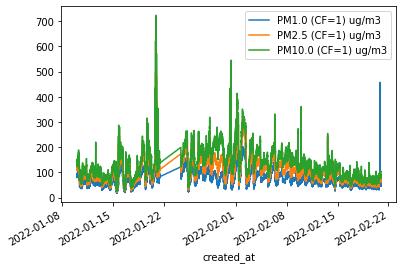

In [3]:
dx[['PM1.0 (CF=1) ug/m3','PM2.5 (CF=1) ug/m3','PM10.0 (CF=1) ug/m3']].plot()

Let's look at it another way

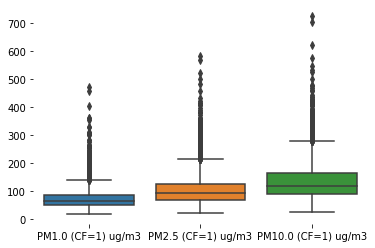

In [4]:
qq = dx[['PM1.0 (CF=1) ug/m3','PM2.5 (CF=1) ug/m3','PM10.0 (CF=1) ug/m3']]
sns.boxplot(data=qq)
sns.despine(left=True,bottom=True)  #offset int, trim = True

What is the relationship between all the variables?

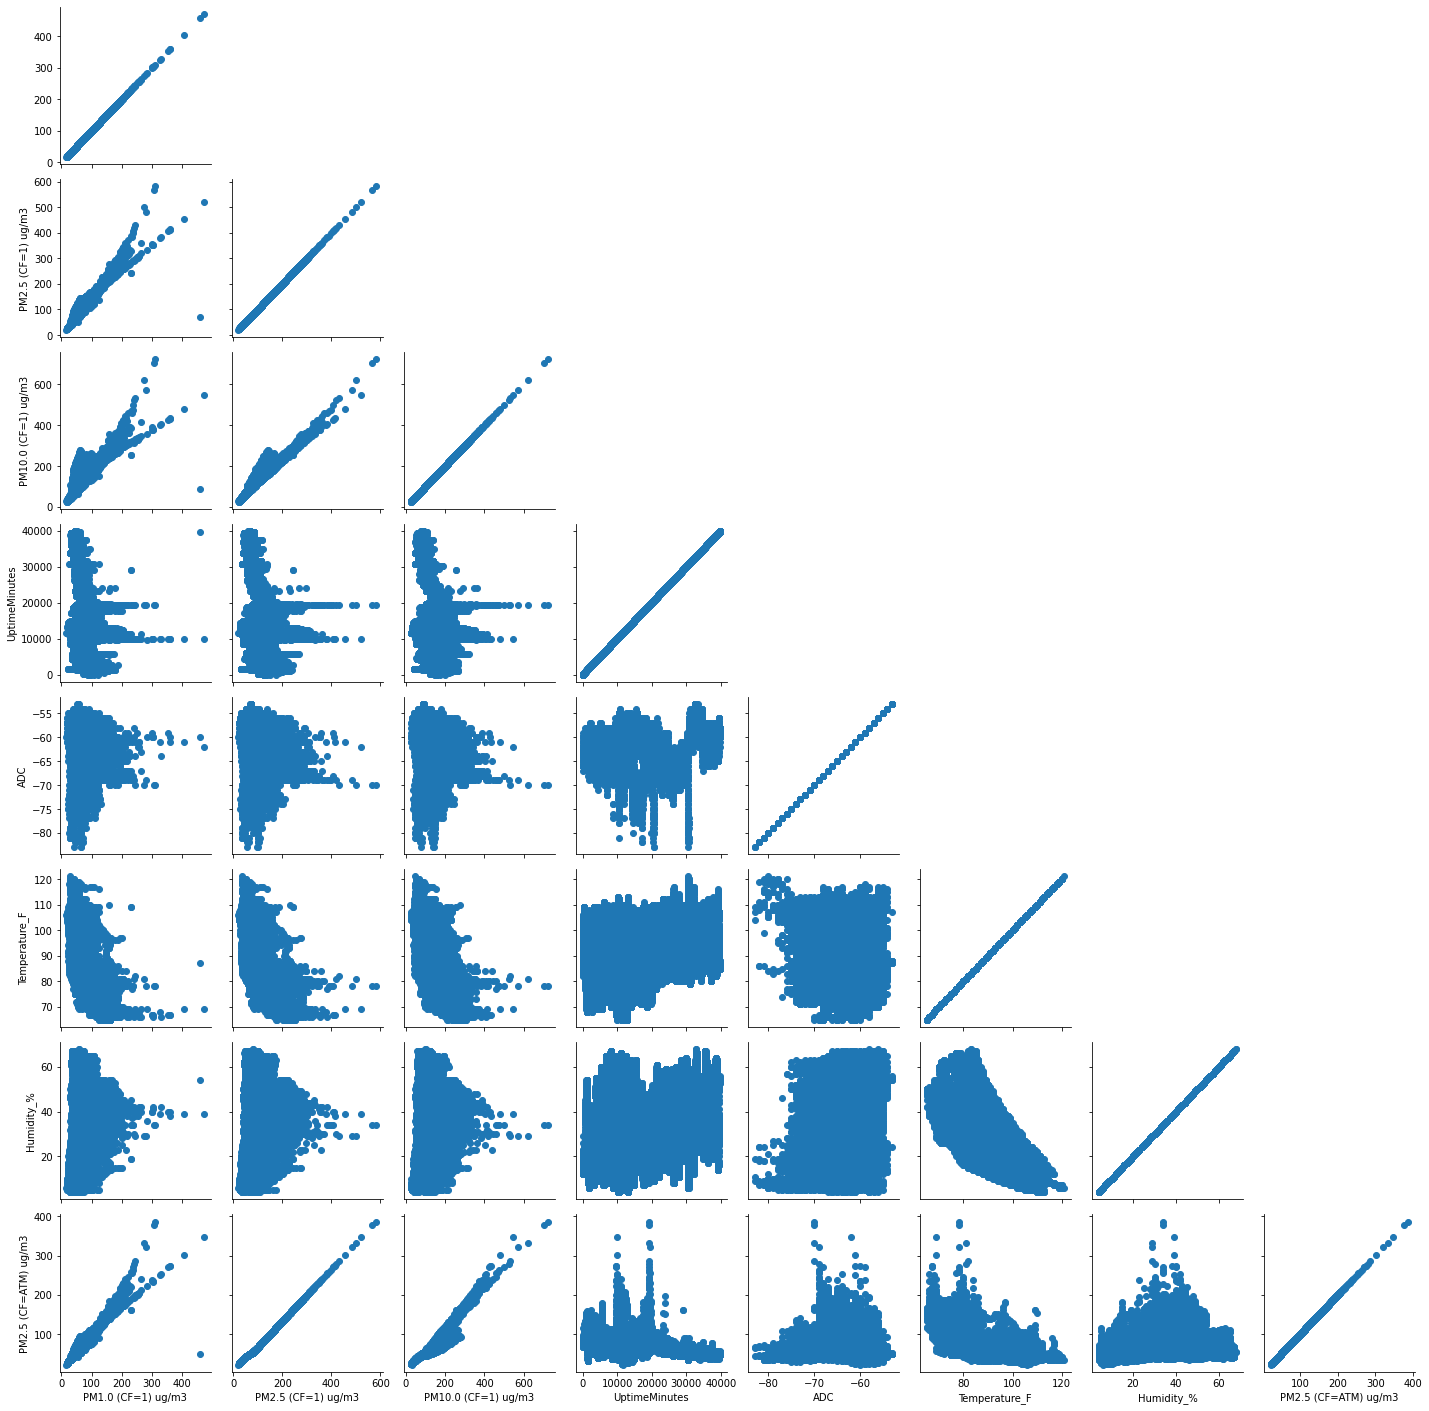

In [5]:
g = sns.PairGrid(dx,corner=True,despine=True)
g.map(plt.scatter);
#g.map_diag(sns.kdeplot)
#g.map_upper(sns.scatterplot)
plt.show()

How about temperature and relative humidity on different y-axis?

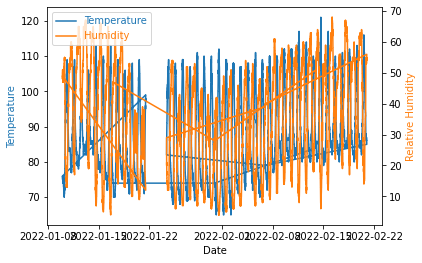

<Figure size 432x288 with 0 Axes>

In [7]:
host = host_subplot(111)

par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("Temperature")
par.set_ylabel("Relative Humidity")

p1, = host.plot(dx['Temperature_F'], label="Temperature")
p2, = par.plot(dx['Humidity_%'], label="Humidity")

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()
plt.savefig('fig2.eps',dpi=1200,format='eps',bbox_inches="tight")

Is it possible to do a spatial plot?

Child 566 lists parent 565, but parent does not exist!
Child 2861 lists parent 2860, but parent does not exist!
Initialized 22,448 sensors!


Text(0.5, 1.0, 'Global temp_c at 2022-02-21 07:40:54')

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


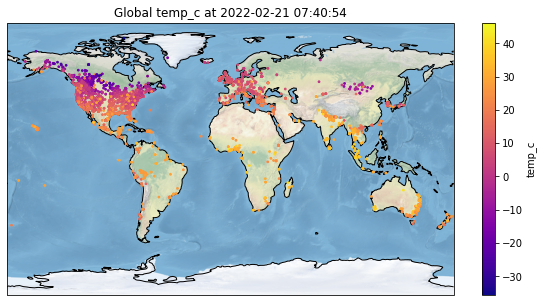

In [8]:
import cartopy.crs as ccrs
VAR_TO_VIZ = 'temp_c'  # The dict item that we want to visualize

# Get PurpleAir data
p = SensorList()
df = p.to_dataframe('all', 'parent')
df = df[df['temp_c'] <= 50]

# Store the lat and lon coords to plot
lat = df['lat'].values
lon = df['lon'].values

# Variable from which to generate the color gradient
colors = df[VAR_TO_VIZ].values

# Create the figure and the axes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Display some map info
ax.set_global()  # Show whole globe
ax.stock_img()  # Use default background image
ax.coastlines()  # Draw coastlines with higher contrast

# Add scatter points for each coordinate pair
scatter = ax.scatter(lon, lat, marker='o', c=colors, cmap='plasma', zorder=5, s=3)

# Add scale
sm = plt.cm.ScalarMappable(cmap='plasma') 
cb = plt.colorbar(scatter).set_label(f'{VAR_TO_VIZ}', rotation=90)

# Draw title and save
ax.set_aspect('auto', adjustable=None)
plt.title(
    f'Global {VAR_TO_VIZ} at {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
